In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import re
from sklearn import datasets, linear_model
import seaborn as sns
from matplotlib import cm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde,ks_2samp,iqr





In [2]:
def get_normalized_mean_amplitude_hwhm_per_epoch(peak_hwhm_csv_list):
    cum_peak_hwhm_dataframe_output = pd.DataFrame (columns = ['epoch','hwhm','amplitude','population'])    
    
    for file in peak_hwhm_csv_list:
        test_df = pd.read_csv(file)
        epochs = test_df['epoch'].drop_duplicates()
        epochs = epochs.to_list()

        populations = ['L2/3']
        populations_multiindex = np.repeat(populations,len(epochs))

        epochs_multiindex = np.tile(epochs,1)

        multiindex_plot = pd.MultiIndex.from_arrays([populations_multiindex,epochs_multiindex],names=('population', 'epoch') )

        for i,measure in enumerate(['amplitude','hwhm']):

            mean_s = test_df.set_index('epoch').groupby(['population', 'epoch'])[measure].mean()
            mean_s = mean_s.reindex(multiindex_plot)
            
            mean_df = mean_s.to_frame()
            mean_df = mean_df.reset_index()

            if measure == 'amplitude': 
                mean_amplitude_df = mean_df
            if measure == 'hwhm': 
                mean_hwhm_df = mean_df

        mean_hwhm_df = mean_hwhm_df.loc[mean_hwhm_df['population']=='L2/3']
        mean_amplitude_df = mean_amplitude_df.loc[mean_amplitude_df['population']=='L2/3']
        
        #Normalize to 'Only L4'
        mean_hwhm_L4input = mean_hwhm_df.hwhm.loc[mean_hwhm_df['epoch']=='Only L4 input'].values
        mean_hwhm_df.hwhm = mean_hwhm_df.hwhm/mean_hwhm_L4input
        mean_amplitude_L4input = mean_amplitude_df.amplitude.loc[mean_amplitude_df['epoch']=='Only L4 input'].values
        mean_amplitude_df.amplitude = mean_amplitude_df.amplitude/mean_amplitude_L4input
        
        mean_hwhm_df['amplitude'] = mean_amplitude_df['amplitude']
        cum_peak_hwhm_dataframe_temp = mean_hwhm_df 
        
        cum_peak_hwhm_dataframe_output = cum_peak_hwhm_dataframe_output.append(cum_peak_hwhm_dataframe_temp)    
    
    
    return cum_peak_hwhm_dataframe_output



In [3]:
parent_folder = '/Users/alexvourvoukelis/Desktop/DTP_rotation_2/Code/L5/simulations'

simulation_dirs = []
peak_hwhm_files = []
for root, directories, files in os.walk(parent_folder, topdown=False):
    for name in files:
        if 'population_peaks' in name:
            peak_hwhm_files.append(os.path.join(root, name))
    for name in directories:
        if 'temporaloffset' in name:
            simulation_dirs.append(os.path.join(root, name))
            

In [4]:
peak_hwhm_files_homogeneous_synch = []

for file in peak_hwhm_files:
    if 'homogeneous' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'asynchronous' not in file:
                    if 'test' in file:
                        peak_hwhm_files_homogeneous_synch.append(file)
peak_hwhm_files_homogeneous_synch.sort()

peak_hwhm_files_homogeneous_asynch = []

for file in peak_hwhm_files:
    if 'homogeneous' in file:
        if '200ms' in file:
            if 'asynchronous' in file:
                if 'test' in file:
                    peak_hwhm_files_homogeneous_asynch.append(file)
peak_hwhm_files_homogeneous_asynch.sort()

peak_hwhm_files_discrete_synch = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'asynchronous' not in file:
                    if 'test' in file:
                        peak_hwhm_files_discrete_synch.append(file)
peak_hwhm_files_discrete_synch.sort()

peak_hwhm_files_discrete_asynch = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'asynchronous' in file:
                if 'test' in file:
                    peak_hwhm_files_discrete_asynch.append(file)
peak_hwhm_files_discrete_asynch.sort()

peak_hwhm_files_discrete_synch_varstr = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'varyingstrength' in file:
                    if 'asynchronous' not in file:
                        peak_hwhm_files_discrete_synch_varstr.append(file)
peak_hwhm_files_discrete_synch_varstr.sort()

peak_hwhm_files_discrete_asynch_varstr = []
for file in peak_hwhm_files:
    if 'discrete' in file:
        if '200ms' in file:
            if 'asynchronous' in file:
                if 'varyingstrength' in file:
                    peak_hwhm_files_discrete_asynch_varstr.append(file)
peak_hwhm_files_discrete_asynch_varstr.sort()


peak_hwhm_files_mixed_synch = []

for file in peak_hwhm_files:
    if 'homogeneous' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'asynchronous' not in file:
                    if 'test' in file:
                        peak_hwhm_files_mixed_synch.append(file)
peak_hwhm_files_mixed_synch.sort()


peak_hwhm_files_mixed_asynch = []

for file in peak_hwhm_files:
    if 'mixed' in file:
        if '200ms' in file:
            if 'synchronous' in file:
                if 'asynchronous' not in file:
                    if 'test' in file:
                        peak_hwhm_files_mixed_asynch.append(file)
peak_hwhm_files_mixed_asynch.sort()


In [5]:
iter_values = []
for file in peak_hwhm_files_discrete_asynch:
    match = re.search('iter\d', file)
    if match and match.group() not in iter_values:
        iter_values.append(match.group())

In [6]:
all_files = {'homogeneous_synchronous': peak_hwhm_files_homogeneous_synch,
             'homogeneous_asynchronous': peak_hwhm_files_homogeneous_asynch,
             'discrete_synchronous': peak_hwhm_files_discrete_synch,
             'discrete_asynchronous': peak_hwhm_files_discrete_asynch,
             'discrete_synchronous_varyingstrength': peak_hwhm_files_discrete_synch_varstr,
             'discrete_asynchronous_varyingstrength': peak_hwhm_files_discrete_asynch_varstr,
             'mixed_synchronous' : peak_hwhm_files_mixed_synch,
             'mixed_asynchronous' : peak_hwhm_files_mixed_asynch}

### Separate by simulation

In [7]:
all_files_separated = dict()

for simulation_label in all_files:
    iter_values = []
    for file in all_files[simulation_label]:
        iter_substring = re.search('iter\d', file)
        if iter_substring and iter_substring.group() not in iter_values:
            iter_values.append(iter_substring.group())
            
    all_files_separated[simulation_label] = dict() 

    for iter_label in iter_values:
        all_files_separated[simulation_label][iter_label] = [file for file in all_files[simulation_label] if iter_label in file] 
        

### Unpack and normalize data in both data storage formats

In [8]:
all_data_pooled = dict()
for label in all_files:
    all_data_pooled[label] = get_normalized_mean_amplitude_hwhm_per_epoch(all_files[label])
    all_data_pooled[label] = all_data_pooled[label].dropna()
    all_data_pooled[label] = all_data_pooled[label].reset_index()


In [9]:
all_data_separated = dict()
for label in all_files_separated:
    all_data_separated[label] = dict()
    for iter_label in all_files_separated[label]:
        all_data_separated[label][iter_label] =  get_normalized_mean_amplitude_hwhm_per_epoch(all_files_separated[label][iter_label])
        all_data_separated[label][iter_label] = all_data_separated[label][iter_label].dropna()
        all_data_separated[label][iter_label] = all_data_separated[label][iter_label].reset_index()

### KDE on asynchronous

In [10]:
all_data_discrete_asynchronous = all_data_pooled['discrete_asynchronous']
all_data_discrete_asynchronous['model_type'] = 'discrete_asynchronous'
all_data_homogeneous_asynchronous = all_data_pooled['homogeneous_asynchronous']
all_data_homogeneous_asynchronous['model_type'] = 'homogeneous_asynchronous'

all_data_pooled_asynchronous = pd.concat([all_data_discrete_asynchronous,all_data_homogeneous_asynchronous])


### Amplitude

In [11]:
ampl_homogeneous_asynchronous = all_data_homogeneous_asynchronous.amplitude.to_numpy()
ampl_discrete_asynchronous = all_data_discrete_asynchronous.amplitude.to_numpy()

In [12]:
# from sklearn.model_selection import GridSearchCV

# bandwidths = 10 ** np.linspace(-1, 1, 100)
# grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                     {'bandwidth': bandwidths},
#                     cv=None)
# grid_hom_asynch_ampl = grid.fit(ampl_homogeneous_asynchronous[:, None]);
# grid_dis_asynch_ampl = grid.fit(ampl_discrete_asynchronous[:, None]);

# print('Homogeneous asynchronous ampl:')
# print(grid_hom_asynch_ampl.best_params_)
# print('Discrete asynchronous ampl:')
# print(grid_dis_asynch_ampl.best_params_)

# Homogeneous asynchronous ampl:
# {'bandwidth': 0.1592282793341092}
# Discrete asynchronous ampl:
# {'bandwidth': 0.1592282793341092}

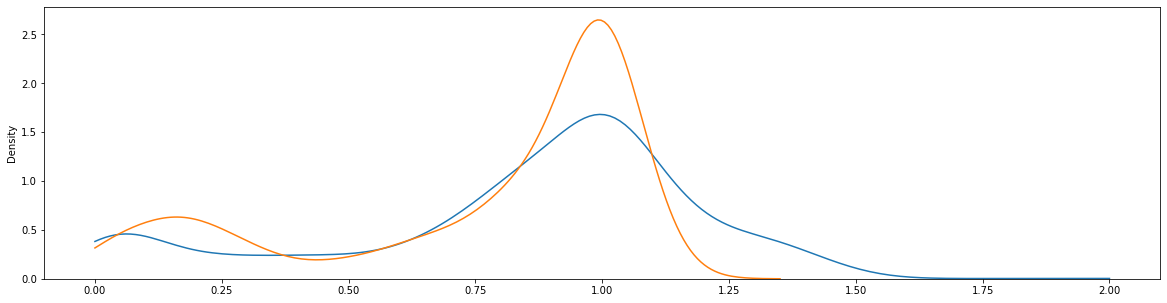

In [27]:
fig = plt.figure(figsize=(20,5))


kde_ampl_discrete_asynchronous = sns.kdeplot(ampl_discrete_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()
kde_ampl_homogeneous_asynchronous = sns.kdeplot(ampl_homogeneous_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()



fig.savefig("/".join((parent_folder,'cumulative_plots','kde_asynchronous_both_all_norm_amplitude.pdf')))
                                    
# ax = sns.kdeplot(ampl_homogeneous_asynchronous,bw_adjust=1,clip=(0,2))
# # calculate the pdf over a range of values
# xx = np.arange(0, 2, 0.001)                                                   
# yy = stats.norm.pdf(xx)                                                         
# # and plot on the same axes that seaborn put the histogram
# ax.plot(xx, yy, 'r', lw=2)     

count    2069.000000
mean        0.759002
std         0.333655
min         0.005609
25%         0.607086
50%         0.927255
75%         1.000000
max         1.133188
Name: amplitude, dtype: float64

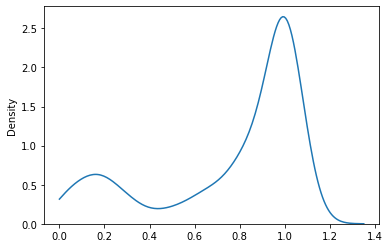

In [14]:
kde_ampl_homogeneous_asynchronous = sns.kdeplot(ampl_homogeneous_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()
all_data_homogeneous_asynchronous.amplitude.describe()



count    3534.000000
mean        0.857228
std         0.435698
min         0.005341
25%         0.695190
50%         0.946589
75%         1.055171
max         3.825620
Name: amplitude, dtype: float64

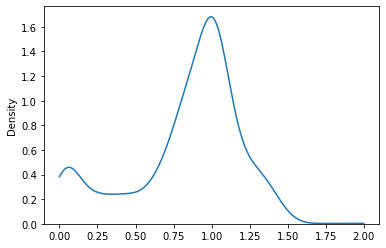

In [15]:
kde_ampl_discrete_asynchronous = sns.kdeplot(ampl_discrete_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()
all_data_discrete_asynchronous.amplitude.describe()

In [16]:
ks_2samp(kde_ampl_homogeneous_asynchronous[1],kde_ampl_discrete_asynchronous[1])

KstestResult(statistic=0.215, pvalue=0.00018395764501293307)

### HWHM

In [17]:
hwhm_homogeneous_asynchronous = all_data_homogeneous_asynchronous.hwhm.to_numpy()
hwhm_discrete_asynchronous = all_data_discrete_asynchronous.hwhm.to_numpy()

In [18]:
# from sklearn.model_selection import GridSearchCV

# bandwidths = 10 ** np.linspace(-1, 1, 100)
# grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                     {'bandwidth': bandwidths},
#                     cv=None)
# grid_hom_asynch_hwhm = grid.fit(hwhm_homogeneous_asynchronous[:, None]);
# grid_dis_asynch_hwhm = grid.fit(hwhm_discrete_asynchronous[:, None]);

# print('Homogeneous asynchronous hwhm:')
# print(grid_hom_asynch_hwhm.best_params_)
# print('Discrete asynchronous hwhm:')
# print(grid_dis_asynch_hwhm.best_params_)

# # Homogeneous asynchronous hwhm:
# # {'bandwidth': 0.1519911082952934}
# # Discrete asynchronous hwhm:
# # {'bandwidth': 0.1519911082952934}

Homogeneous asynchronous hwhm:
{'bandwidth': 0.1519911082952934}
Discrete asynchronous hwhm:
{'bandwidth': 0.1519911082952934}


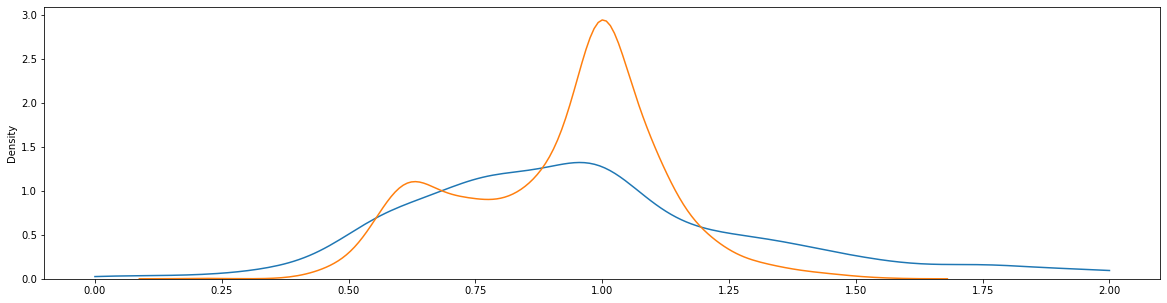

In [26]:
fig = plt.figure(figsize=(20,5))

kde_hwhm_discrete_asynchronous = sns.kdeplot(hwhm_discrete_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()
kde_hwhm_homogeneous_asynchronous = sns.kdeplot(hwhm_homogeneous_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()

fig.savefig("/".join((parent_folder,'cumulative_plots','kde_asynchronous_both_all_norm_hwhm.pdf')))

count    2069.000000
mean        0.918075
std         0.196901
min         0.215812
25%         0.765755
50%         0.971894
75%         1.042187
max         1.552172
Name: hwhm, dtype: float64

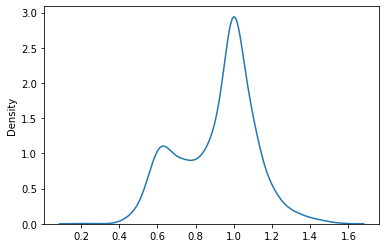

In [20]:
kde_hwhm_homogeneous_asynchronous = sns.kdeplot(hwhm_homogeneous_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()
all_data_homogeneous_asynchronous.hwhm.describe()

count    3534.000000
mean        0.991127
std         0.404094
min         0.002083
25%         0.731132
50%         0.941669
75%         1.154375
max         3.403086
Name: hwhm, dtype: float64

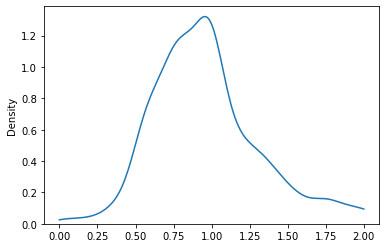

In [21]:
kde_hwhm_discrete_asynchronous = sns.kdeplot(hwhm_discrete_asynchronous,bw_adjust=1,clip=(0,2)).get_lines()[0].get_data()
all_data_discrete_asynchronous.hwhm.describe()

# np.std(all_data_discrete_asynchronous.hwhm.to_numpy())

In [22]:
ks_2samp(kde_hwhm_homogeneous_asynchronous[1],kde_hwhm_discrete_asynchronous[1])

KstestResult(statistic=0.3, pvalue=2.4125498977354686e-08)